# Minigame 11: Choose One Element To Refine And Advect Mesh

Experiment: try a 50/50 chance of advecting one element left or one element right, with the direction as part of the observation.

This is like minigame10, except that we're now "advecting" the field by displacing the mesh. This is like a remap method, where the remap is just to re-project the known function onto the new mesh.

In this context, we want to refine not where our finest features are right now, but where they will be after the advection. In this sense, the policy has a way to do "anticipatory" refinement, which is a new strategic consideration for the policy. The DG indicator doesn't take this into account, so the policy at least in principle may be able to get ahead here.

In a typical AMR code, this is usually accounted for by "buffering" refined areas, so that refined features do not leave a refined zone before the next regrid phase. This buffering is ad-hoc and doesn't usually take into account, for example, the local direction of advection.

Setup PyMFEM:

In [1]:
import math
from math import cos,sin
import random

In [2]:
import sys
import gym
from gym import spaces, utils
import numpy as np
import ray
import ray.rllib.agents.ppo as ppo

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from pyglvis import GlvisWidget

In [4]:
import matplotlib.pyplot as plt

In [5]:
from mfem import path
import mfem.ser as mfem

This is a utility function for using pyglvis

In [6]:
def get_solnstream(mesh,soln):
    mesh.Print(",tmpmesh")
    with open(",tmpmesh","r") as f:
        meshdata = f.read()
    soln.Save(",tmpsoln")
    with open(",tmpsoln","r") as f:
        solndata = f.read()
    solndata = "solution\n"+meshdata+solndata
    return solndata

Define some synthetic test functions: steps and bumps.

In [7]:
def rotate(x,theta):
    x0 = x[0]
    y0 = x[1]
    x1 = x0*cos(theta)-y0*sin(theta)
    y1 = x0*sin(theta)+y0*cos(theta)
    return [x1,y1]

In [8]:
def step(x):
    x0 = x[0]
    if (x0 < 0.0):
        return 1.0
    else:
        return 0.0

In [9]:
def rotated_step(x, theta):
    xr = rotate(x,theta)
    return step(xr)

In [10]:
def bump(x):
    rsq = x[0]**2 +x[1]**2
    return math.exp(-rsq)

In [11]:
def smooth_step(x):
    return 0.5*(1.0 +math.tanh(x[0]))

In [12]:
def rotated_smooth_step(x,theta):
    xr = rotate(x,theta)
    return smooth_step(xr)

Create classes where we can set the parameters and then eval a bunch of points.

In [13]:
class Step(mfem.PyCoefficient):
    
    def SetParams(self):
        self.theta = random.uniform(0.0, 2.0*math.pi)
        self.dx = [random.uniform(-1.0, 1.0),random.uniform(-1.0, 1.0)]
        
    def EvalValue(self, x):
        return rotated_step(x+self.dx, self.theta)

In [14]:
class Bump(mfem.PyCoefficient):
    
    def SetParams(self):
        self.width = random.uniform(0.1,1.0)
        self.xc = [0.5,0.5]
        self.dx = [random.uniform(-0.5, 0.5),random.uniform(-0.5, 0.5)]

    def EvalValue(self, x):
        return bump((x-self.xc+self.dx)/self.width)

In [15]:
class TwoBump(mfem.PyCoefficient):
    
    def SetParams(self):
        self.width1 = random.uniform(0.1,0.5)
        self.width2 = random.uniform(0.1,0.5)
        self.xc1 = [0.5,0.5]
        self.xc2 = [0.5,0.5]
        self.dx1 = [random.uniform(-0.5, 0.5),random.uniform(-0.5, 0.5)]
        self.dx2 = [random.uniform(-0.5, 0.5),random.uniform(-0.5, 0.5)]

    def EvalValue(self, x):
        #return max(bump((x-self.xc1+self.dx1)/self.width1),bump((x-self.xc2+self.dx2)/self.width2))
        return 0.5*(bump((x-self.xc1+self.dx1)/self.width1)+bump((x-self.xc2+self.dx2)/self.width2))

In [16]:
class SmoothStep(mfem.PyCoefficient):
    
    def SetParams(self):
        self.width = random.uniform(5.0, 10.0)
        self.xc = [0.5,0.5]
        self.theta = random.uniform(0.0, 2.0*math.pi)

    def EvalValue(self, x):
        x -= self.xc
        return rotated_smooth_step(x*self.width, self.theta)

In [17]:
class BumpsAndSmoothStep(mfem.PyCoefficient):
    
    def SetParams(self):
        self.bump = Bump()
        self.bump.SetParams()
        self.smooth_step = SmoothStep()
        self.smooth_step.SetParams()

    def EvalValue(self, x):
        return 0.5*self.bump.EvalValue(x)+0.5*self.smooth_step.EvalValue(x)


Visualize an instance of the test function. Note that each instance has randomly chosen parameters.  For the steps, it's a rotation angle and a displacement.  For the bumps, it's a width and a displacement.

In [18]:
mesh = mfem.Mesh('inline-quad.mesh')
mesh.UniformRefinement()
mesh.UniformRefinement()
mesh.UniformRefinement()
fec = mfem.L2_FECollection(p=1, dim=2)
fes = mfem.FiniteElementSpace(mesh, fec)
u = mfem.GridFunction(fes)
c = BumpsAndSmoothStep()
c.SetParams()
u.ProjectCoefficient(c)

In [19]:
gl = GlvisWidget(get_solnstream(mesh,u))
gl

GlvisWidget()

Create the gym environment.

In [20]:
class AMRGame(gym.Env):
    
    class u0_coeff(mfem.PyCoefficient):
        
        def SetParams(self):
            self.fn = BumpsAndSmoothStep()
            self.fn.SetParams()
            
        def EvalValue(self, x):
            return self.fn.EvalValue(x)
    
    def set_displ(self):
        self.ud = random.uniform(-1.0, 1.0)
        self.vd = random.uniform(-1.0, 1.0)
        
        # tmp - simpler velocity model
        self.ud = 0.0
        self.vd = 0.0
        alpha = random.uniform(0.0, 1.0)
        if (alpha > 0.5):
            self.ud = 1.0
        else:
            self.ud = -1.0

        mag = math.sqrt(self.ud**2 +self.vd**2)
        nx = math.sqrt(self.mesh.GetNE())
        self.ud /= mag
        self.ud /= nx
        self.vd /= mag
        self.vd /= nx
            
        nv = self.mesh.GetNV()
        uda = np.full((nv),self.ud)
        vda = np.full((nv),self.vd)
        uvda = np.concatenate((uda,vda))
        self.displ = mfem.Vector(nv*2)
        self.displ.Assign(uvda)
        
    # In RLlib, you need the config arg
    def __init__(self,config):
        self.meshfile = 'inline-quad-7.mesh'
        
        # keep a copy of the unrefined mesh so we can restore it
        self.mesh0 = mfem.Mesh(self.meshfile)
        self.mesh = mfem.Mesh(self.meshfile)
        
        # The only reason we need to create a fespace and gf here
        # is to find the sizes needed for the action and observation spaces
        dim = self.mesh.Dimension()
        self.order = 1
        self.fec = mfem.L2_FECollection(self.order, dim)
        self.fes = mfem.FiniteElementSpace(self.mesh, self.fec)
        self.u = mfem.GridFunction(self.fes);

        # actions are: refine each element, or do nothing
        self.action_space = spaces.Discrete(self.mesh.GetNE())
        
        # observation space: DOFs plus two velocity components
        self.observation_space = spaces.Box(-1.0, 1.0, shape=(self.u.Size()+2,), dtype=np.float32)
        
        # call reset to create the first synthetic function
        self.reset()
                
    def get_ne(self):
        return self.mesh.GetNE()
    
    def get_size(self):
        return self.u.Size()
    
    # Compute L2 error wrt to the analytic fn definition
    def get_error(self):
        err = self.u.ComputeL2Error(self.u0)
        return err
    
    # Manually refine the elements, then update and re-project
    def refine_elems(self, elems):
        self.mesh.GeneralRefinement(mfem.intArray(elems))
        self.fes.Update()
        self.u.Update()
        self.u.ProjectCoefficient(self.u0)
        
    # action is the number of the element to refine
    def step(self, action):
        err1 = self.get_error()
        self.mesh.MoveVertices(self.displ)
        self.refine_elems([action])
        
        err2 = self.get_error()
        reward = err1-err2
        done = True
        
        obs = self.u.GetDataArray()
        obs = np.append(obs,[self.ud, self.vd])
        return np.array(obs), reward, done, {}
    
    # similar to reset, but do not choose a new function
    def reinit(self):
        del self.mesh
        self.mesh = mfem.Mesh(self.mesh0)

        del self.fes
        self.fes = mfem.FiniteElementSpace(self.mesh, self.fec)

        del self.u
        self.u = mfem.GridFunction(self.fes)
        self.u.ProjectCoefficient(self.u0)
        
        obs = self.u.GetDataArray()
        obs = np.append(obs,[self.ud, self.vd])
        return np.array(obs)
    
    # every reset of the env chooses a new synthetic function
    def reset(self):
        self.u0 = self.u0_coeff()
        
        # set the random function parameters
        self.u0.SetParams()
        
        # set the random mesh displacement
        self.set_displ()
        
        return self.reinit()
    
    def render(self):
        return GlvisWidget(get_solnstream(self.mesh,self.u))

Instantiate the environment and sanity check it.

In [21]:
env = AMRGame(None)

In [22]:
env = AMRGame(None)
obs = env.reset()

In [23]:
env.render()

GlvisWidget()

In [24]:
state, reward, done, info = env.step(0)

In [25]:
env.render()

GlvisWidget()

Show with refinement of element 0. Then we'll test resetting it to the original state.  We're going to need this to go through a searching for the best actions.

In [26]:
env.reinit()
env.render()

GlvisWidget()

Ok, try training a policy

In [27]:
ray.shutdown()
# This env setting is necessary to avoid problems within rllib due to serialization and workers
ray.init(ignore_reinit_error=True)
config = ppo.DEFAULT_CONFIG.copy()
config['train_batch_size'] = int(1e4)
config['num_workers'] = 3
config['framework'] = 'tfe'
config

2021-02-14 22:05:27,974	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8267


{'num_workers': 3,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 200,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 10000,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_action_dist': None,
  'custom_preprocessor': None,
  'lstm_use_prev_action_reward': -1},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': None,
 'normalize_actions': False,
 'clip_rewards': None,
 'clip_actions': True,
 'preproc

In [28]:

config['train_batch_size'] = int(1e3)
agent = ppo.PPOTrainer(config, env=AMRGame)

2021-02-14 22:05:30,575	INFO trainer.py:588 -- Executing eagerly, with eager_tracing=False
2021-02-14 22:05:30,576	INFO trainer.py:618 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=18092) WARNING:tensorflow:From /home/rwa/pyvenv/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=18092) Instructions for updating:
(pid=18092) non-resource variables are not supported in the long term
(pid=18090) WARNING:tensorflow:From /home/rwa/pyvenv/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=18090) Instructions for updating:
(pid=18090) non-resource variables are not supported in the long term
(pid=18093) WARNING:tensorflow:Fro

In [29]:
%%time
for n in range(1):
    result = agent.train()
    print("episode reward mean: %f " % result["episode_reward_mean"])

(pid=18093) 2021-02-14 22:05:33,993	WARNING deprecation.py:30 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!
(pid=18090) /home/rwa/pyvenv/lib/python3.6/site-packages/ray/rllib/evaluation/collectors/simple_list_collector.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
(pid=18090)   arr = np.array(v)
(pid=18092) /home/rwa/pyvenv/lib/python3.6/site-packages/ray/rllib/evaluation/collectors/simple_list_collector.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
(pid=18092)   

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
episode reward mean: -0.000135 
CPU times: user 7.22 s, sys: 225 ms, total: 7.45 s
Wall time: 16.6 s


(pid=18090) WARNING:tensorflow:From /home/rwa/pyvenv/lib/python3.6/site-packages/ray/rllib/policy/tf_policy.py:852: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
(pid=18090) Instructions for updating:
(pid=18090) Prefer Variable.assign which has equivalent behavior in 2.X.
(pid=18093) WARNING:tensorflow:From /home/rwa/pyvenv/lib/python3.6/site-packages/ray/rllib/policy/tf_policy.py:852: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
(pid=18093) Instructions for updating:
(pid=18093) Prefer Variable.assign which has equivalent behavior in 2.X.


In [30]:
policy = agent.get_policy()
model = policy.model
print(model.base_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 198)]        0                                            
__________________________________________________________________________________________________
fc_1 (Dense)                    (None, 256)          50944       observations[0][0]               
__________________________________________________________________________________________________
fc_value_1 (Dense)              (None, 256)          50944       observations[0][0]               
__________________________________________________________________________________________________
fc_2 (Dense)                    (None, 256)          65792       fc_1[0][0]                       
______________________________________________________________________________________________

Create a convenience function for applying a policy to a given observation

In [31]:
def apply_policy(model, obs):
    action = agent.compute_action(obs, explore=False) # use deterministic mode
    state, reward, done, info = env.step(action)
    #print("policy chooses action %d with reward %f" % (action, reward))
    return action, reward

In [32]:
obs = env.reset()
env.render()

(pid=18092) WARNING:tensorflow:From /home/rwa/pyvenv/lib/python3.6/site-packages/ray/rllib/policy/tf_policy.py:852: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
(pid=18092) Instructions for updating:
(pid=18092) Prefer Variable.assign which has equivalent behavior in 2.X.


GlvisWidget()

In [33]:
action, reward = apply_policy(model, obs)
action, reward
env.render()

GlvisWidget()

In [34]:
obs = env.reinit()
action, reward = apply_policy(model, obs)
action, reward

(37, -0.0007983550520610262)

In [35]:
env.render()

GlvisWidget()

Brute force search for the best choice by trying each one, remembering to reset the environment after each action and after we're done.

In [36]:
def find_optimal(obs):
    u0 = mfem.Vector(obs)
    maxr = 0.0;
    maxel = -1;
    env.reinit()
    ne = env.get_ne()
    for n in range(ne):
        env.reinit()
        state, reward, done, info = env.step(n)
        if reward > maxr:
            maxr = reward
            maxel = n
    #print("max reward is %f by refining element %d" % (maxr, maxel))
    env.reinit()
    return maxel, maxr

In [37]:
obs = env.reinit()
maxel, maxr = find_optimal(obs)
env.step(maxel)
env.render()

GlvisWidget()

Compare with what the policy does:

In [38]:
env.reinit()
apply_policy(model,obs)
env.render()

GlvisWidget()

Define an error estimator based on the difference between the discontinuous and continuous representations. This is only valid for L2 FE spaces.

In [39]:
def find_dgjumps(env):
    
    mesh = env.mesh
    u = env.u
    
    # put the L2 gridfunction into a coefficient so we can project it
    u_disc_coeff = mfem.GridFunctionCoefficient(u)
    h1_fec = mfem.H1_FECollection(p=1, dim=2)
    h1_fes = mfem.FiniteElementSpace(mesh, h1_fec)
    u_h1 = mfem.GridFunction(h1_fes)
    u_h1.ProjectDiscCoefficient(u_disc_coeff, mfem.GridFunction.ARITHMETIC)
    
    # put the H1 smoothed function into a coefficient
    u_h1_coeff = mfem.GridFunctionCoefficient(u_h1)
    
    # create a 0-order L2 field to hold errors
    l2_0_fec = mfem.L2_FECollection(p=0,dim=2)
    l2_0_fes = mfem.FiniteElementSpace(mesh,l2_0_fec)

    # Compute elementwise "errors" between continuous and discontinuous fields
    err_gf = mfem.GridFunction(l2_0_fes);
    u.ComputeElementL2Errors(u_h1_coeff, err_gf);
    
    best_action = np.argmax(err_gf.GetDataArray())
    
    state, reward, done, info = env.step(best_action)
    env.reinit()

    return best_action, reward

In [40]:
env.reinit()
action, reward = find_dgjumps(env)
env.step(action)
env.render()

GlvisWidget()

A random policy gives us a scale for the low end.

In [41]:
def apply_random_policy(obs):
    ne = env.get_ne()
    ir = np.random.randint(0,ne)
    state, reward, done, info = env.step(ir)
    env.reinit()
    return ir, reward

Run a more systematic evaluation using an ensemble of samples:

In [42]:
def eval_ensemble(model, ntrials):
    
    ncorrect = 0
    sumsq = 0.0
    maxerrsq = 0.0
    
    dg_ncorrect = 0
    dg_sumsq = 0.0
    dg_maxerrsq = 0.0
    
    rand_ncorrect = 0
    rand_sumsq = 0.0
    rand_maxerrsq = 0.0
    for n in range(ntrials):
        obs = env.reset()
        
        bestaction, bestreward = find_optimal(obs) # this reinits
        dgaction, dgreward = find_dgjumps(env)     # this reinits
        action, reward = apply_policy(model,obs)   # this doesn't reinit
        env.reinit()
        rand_action, rand_reward = apply_random_policy(obs)
        
        err = bestreward-reward
        maxerrsq = max(err**2,maxerrsq)
        sumsq += err**2
        
        dg_err = bestreward-dgreward
        dg_maxerrsq = max(dg_err**2,dg_maxerrsq)
        dg_sumsq += dg_err**2
        
        rand_err = bestreward-rand_reward
        rand_maxerrsq = max(rand_err**2,rand_maxerrsq)
        rand_sumsq += rand_err**2
        
        if (bestaction == action):
            ncorrect += 1
        if (bestaction == dgaction):
            dg_ncorrect += 1
        if (bestaction == rand_action):
            rand_ncorrect += 1
    
    rms = math.sqrt(sumsq/ntrials)
    corr = 100.*ncorrect/ntrials
    print("policy rms error: ",rms,flush=True)
    print("policy max sq error: ",math.sqrt(maxerrsq),flush=True)
    print("policy % correct: ",corr,flush=True)
    
    dg_rms = math.sqrt(dg_sumsq/ntrials)
    dg_corr = 100.*dg_ncorrect/ntrials
    print("dg rms error: ",dg_rms,flush=True)
    print("dg max sq error: ",math.sqrt(dg_maxerrsq),flush=True)
    print("dg % correct: ",dg_corr,flush=True)
    
    rand_rms = math.sqrt(rand_sumsq/ntrials)
    rand_corr = 100.*rand_ncorrect/ntrials
    print("rand rms error: ",rand_rms,flush=True)
    print("rand max sq error: ",math.sqrt(rand_maxerrsq),flush=True)
    print("rand % correct: ",rand_corr,flush=True)
    
    return rms, math.sqrt(maxerrsq), corr, dg_rms, math.sqrt(dg_maxerrsq), dg_corr, rand_rms, math.sqrt(rand_maxerrsq), rand_corr

eval_ensemble(model, 100)

Run a few eval sample sizes to get a sense of how many are needed to estimate the metrics of the policy

eval_ensemble(model, 200)

eval_ensemble(model, 400)

Let's see if the training process is making progress:

In [43]:
def train_phase(nbatches, neval):
    start_batches = len(rms)
    for n in range(nbatches):
        done_batches = len(rms)
        print("training batch %d/%d (%d episodes)" % (done_batches,start_batches+nbatches,batch_size))
        agent.train()
        agent.save()
        print("evaluating on %d instances..." %  neval)
        rms0, maxerr0, cor0, dg_rms0, dg_maxerr0, dg_cor0, rand_rms0, rand_maxerr0, rand_cor0 = eval_ensemble(model, neval)
        rms.append(rms0)
        maxerr.append(maxerr0)
        cor.append(cor0)
        dg_rms.append(dg_rms0)
        dg_maxerr.append(dg_maxerr0)
        dg_cor.append(dg_cor0)
        rand_rms.append(rand_rms0)
        rand_maxerr.append(rand_maxerr0)
        rand_cor.append(rand_cor0)

In [44]:
phase_episodes = 5.e5
nbatches = 5
batch_size = phase_episodes/nbatches
neval = 400

del agent
config['train_batch_size'] = int(batch_size)
agent = ppo.PPOTrainer(config, env=AMRGame)
policy = agent.get_policy()
model = policy.model

rms = []
maxerr = []
cor = []
dg_rms = []
dg_maxerr = []
dg_cor = []
rand_rms = []
rand_maxerr = []
rand_cor = []

(pid=18091) WARNING:tensorflow:From /home/rwa/pyvenv/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=18091) Instructions for updating:
(pid=18091) non-resource variables are not supported in the long term
2021-02-14 22:05:54,578	WARNING util.py:43 -- Install gputil for GPU system monitoring.


In [45]:
train_phase(nbatches, neval)

training batch 0/5 (100000 episodes)


(pid=18365) WARNING:tensorflow:From /home/rwa/pyvenv/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=18365) Instructions for updating:
(pid=18365) non-resource variables are not supported in the long term
(pid=18367) WARNING:tensorflow:From /home/rwa/pyvenv/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=18367) Instructions for updating:
(pid=18367) non-resource variables are not supported in the long term
(pid=18091) 2021-02-14 22:05:57,920	WARNING deprecation.py:30 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!
(pid=18091) /home/rwa/pyvenv/lib/python3.6/site-packages/ray/rllib/evaluation/collectors/simple_

evaluating on 400 instances...
policy rms error:  0.0004899636345431394
policy max sq error:  0.0023890152698299695
policy % correct:  2.5
dg rms error:  0.0003924039173737348
dg max sq error:  0.0020401561015551154
dg % correct:  8.0
rand rms error:  0.0004862213171173368
rand max sq error:  0.002382961110101945
rand % correct:  2.25
training batch 1/5 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.0005880505019909671
policy max sq error:  0.004067021464096893
policy % correct:  4.75
dg rms error:  0.0005112923223985645
dg max sq error:  0.003694416106626278
dg % correct:  6.0
rand rms error:  0.0005854705729294449
rand max sq error:  0.0038389212367868335
rand % correct:  2.5
training batch 2/5 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.0004909115812047739
policy max sq error:  0.003351044248972552
policy % correct:  6.75
dg rms error:  0.00041161361075468876
dg max sq error:  0.002690644855932109
dg % correct:  4.75
rand rms error:  

In [46]:
%matplotlib inline

def plotprogress():
    isteps = list(range(len(rms)))
    asteps = [(i+1)*config['train_batch_size'] for i in isteps]
    ax = plt.subplot(211)
    #ax.set_ylim(0.0001,0.01)
    ax.set_ylabel('Loss')
    line1, = plt.semilogy(asteps,rms, marker='o')
    line2, = plt.semilogy(asteps,dg_rms, marker='x')
    line3, = plt.semilogy(asteps,rand_rms)

    line4, = plt.semilogy(asteps,maxerr, marker='.')
    line5, = plt.semilogy(asteps,dg_maxerr, marker='+')
    line6, = plt.semilogy(asteps,rand_maxerr)

    line1.set_label('RL rms')
    line2.set_label('DG rms')
    line3.set_label('RNG rms')
    line4.set_label('RL max')
    line5.set_label('DG max')
    line6.set_label('RNG max')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    ax = plt.subplot(212)
    ax.set_ylim(1,100)
    ax.set_ylabel('% correct')
    ax.set_xlabel('training episodes')
    line1, = plt.semilogy(asteps,cor, marker='o')
    line2, = plt.semilogy(asteps,dg_cor, marker='x')
    line3, = plt.semilogy(asteps,rand_cor)

    line1.set_label('RL')
    line2.set_label('DG')
    line3.set_label('RNG')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

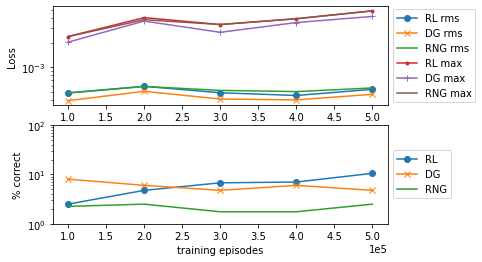

In [47]:
plotprogress()

In [48]:
train_phase(nbatches, neval)

training batch 5/10 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.00047939292449630566
policy max sq error:  0.004467290499534069
policy % correct:  9.25
dg rms error:  0.0004111591666773545
dg max sq error:  0.003727840328422577
dg % correct:  6.25
rand rms error:  0.0005291009092211208
rand max sq error:  0.004467446673210319
rand % correct:  2.0
training batch 6/10 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.0005123374619473343
policy max sq error:  0.003833936033702032
policy % correct:  13.5
dg rms error:  0.00047272636603412307
dg max sq error:  0.003415862687239756
dg % correct:  4.25
rand rms error:  0.0005859203763401369
rand max sq error:  0.003830936926453741
rand % correct:  1.75
training batch 7/10 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.0006198499338097253
policy max sq error:  0.004271699968091061
policy % correct:  12.25
dg rms error:  0.0005475633358246718
dg max sq error:  0.00365185211431

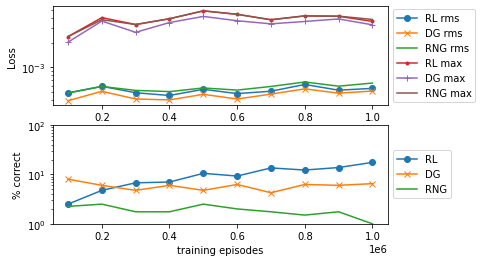

In [49]:
plotprogress()

In [50]:
train_phase(nbatches, neval)

training batch 10/15 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.0005218642937857421
policy max sq error:  0.003211543022778947
policy % correct:  15.75
dg rms error:  0.0004958179186223643
dg max sq error:  0.002833524312951324
dg % correct:  6.75
rand rms error:  0.0006106276460621503
rand max sq error:  0.003220687109654571
rand % correct:  1.75
training batch 11/15 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.00036253213952916165
policy max sq error:  0.002646582003323685
policy % correct:  19.25
dg rms error:  0.00043335529381464765
dg max sq error:  0.0029148270728444822
dg % correct:  4.25
rand rms error:  0.0004973658097367496
rand max sq error:  0.003471151485535142
rand % correct:  3.25
training batch 12/15 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.0003625931597503138
policy max sq error:  0.0026408154513561013
policy % correct:  20.5
dg rms error:  0.00042653065544040084
dg max sq error:  0.003134

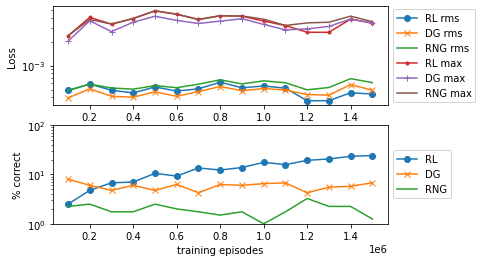

In [51]:
plotprogress()

In [52]:
train_phase(nbatches, neval)

training batch 15/20 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.0004289260220399312
policy max sq error:  0.00444736089893045
policy % correct:  27.25
dg rms error:  0.0006007021351025198
dg max sq error:  0.00444736089893045
dg % correct:  4.75
rand rms error:  0.0007129059296225891
rand max sq error:  0.005047937693991469
rand % correct:  1.25
training batch 16/20 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.0003758529113278041
policy max sq error:  0.0035138048208813253
policy % correct:  22.75
dg rms error:  0.0005540337283669703
dg max sq error:  0.003671629184700014
dg % correct:  7.0
rand rms error:  0.0006800877935251067
rand max sq error:  0.004382380245329176
rand % correct:  2.0
training batch 17/20 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.00021053434676362117
policy max sq error:  0.0016272671284956464
policy % correct:  28.75
dg rms error:  0.0004121035150711173
dg max sq error:  0.00377463763

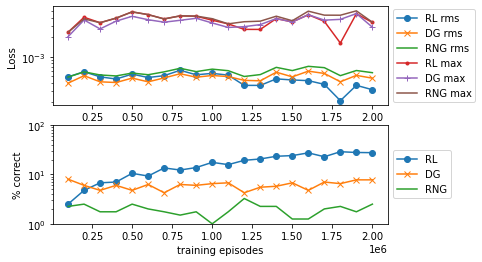

In [53]:
plotprogress()

Let's look for cases where the policy gets it right and the DG method gets it wrong.

for n in range(500):
    obs = env.reset()
    opt_action, opt_reward = find_optimal(obs)
    dg_action, dg_reward = find_dgjumps(env)
    pol_action, pol_reward = apply_policy(model, obs)
    if ((pol_action == opt_action) and (dg_action != opt_action)):
        break
env.reinit()
env.step(pol_action)
env.render()

env.reinit()
env.step(dg_action)
env.render()

training batch 20/25 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.000346001842108791
policy max sq error:  0.0033319746630079
policy % correct:  31.75
dg rms error:  0.0005164254491227194
dg max sq error:  0.0033319746630079
dg % correct:  5.75
rand rms error:  0.0006448298377549167
rand max sq error:  0.0037592229488657408
rand % correct:  3.0
training batch 21/25 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.00044919575846011703
policy max sq error:  0.0040567688360149436
policy % correct:  29.75
dg rms error:  0.000573209253524108
dg max sq error:  0.003759502118006519
dg % correct:  6.25
rand rms error:  0.0007090655842461778
rand max sq error:  0.004559101306740634
rand % correct:  1.0
training batch 22/25 (100000 episodes)
evaluating on 400 instances...
policy rms error:  0.00021846083720230677
policy max sq error:  0.0024866917866264403
policy % correct:  31.75
dg rms error:  0.00039704013792864554
dg max sq error:  0.003179521993

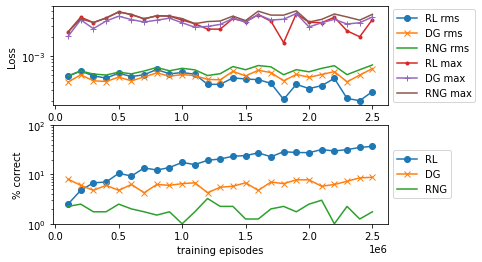

In [54]:
train_phase(nbatches, neval)
plotprogress()